In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.models import inception_v3
import torchvision.utils as vutils

import math, scipy.linalg
from google.colab import drive

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
device

'cuda'

In [4]:
torch.cuda.empty_cache()

## Загрузка датасета

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
img_size = 64
batch_size = 64

In [7]:
transform = transforms.Compose([transforms.Resize((img_size,img_size)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5),
                                             (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder('/content/drive/MyDrive/landscapes', transform=transform)

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
images, labels = next(iter(dataloader))

In [9]:
# вспомогательная функция для денормализации изображения и
# преобразования тензора в np.array для дальнейшей визуализации
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)

    return image

In [ ]:
img = im_convert(images[0])

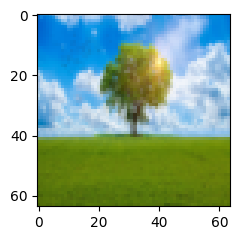

In [ ]:
# визуализация
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.imshow(img)
plt.show()

## Diffusion forward process  
Нам необязательно добавлять шум последовательно. Мы можем перейти от исходного изображения X0 к любому зашумленному Xt за один шаг. Зададим коэффициенты и формулы для этого процесса.

In [10]:
# зададим коэффициенты beta линейно, как в статье Ho et al., но количество шагов - 500, а не 1000
T = 500
betas = torch.linspace(start = 0.0001, end = 0.02, steps = T)
#посчитаем остальные использующиеся коэффициенты
alphas = 1. - betas

alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_previous = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) #для подсчета фиксированных дисперсий
posterior_variance = betas * (1. - alphas_cumprod_previous) / (1. - alphas_cumprod) # дисперсии, используемые для сэмплирования

sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

In [11]:
# вспомогательная функция
def get_index_from_list(vals, t, x_shape):
    """
    Возвращает из тензора vals значения с индексами из тензора t с учетом размера батча
    Потребуется, чтобы получить значения sqrt_alphas_cumprod при определенных t
    """
    b_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(b_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [12]:
def forward_diffusion_sample(x_0, t, device = device):
    """
    Принимает исходное изображение X0 и t, чтобы возвратить зашумленную версию Xt
    """
    noise = torch.randn_like(x_0) #шум такой же формы, как x_0
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # возвращает по формуле Xt и добавленный шум (шум необходимо запомнить)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

Проиллюстрируем процесс зашумления изображения на 1 примере

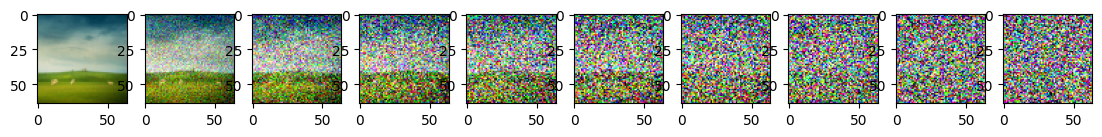

In [ ]:
true_image = next(iter(dataloader))[0][0]

num_images = 10
stepsize = int(T/num_images)

plt.figure(figsize=(15,15))
plt.axis('off')

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    latent, noise = forward_diffusion_sample(true_image, t)
    latent_img = im_convert(latent)
    plt.imshow(latent_img)

## Архитектура нейросети

Будет использоваться простая сеть UNet с позиционными эмбеддингами (кодироваться будут t). Это нужно, поскольку, не зная t, модель будет одинаково обрабатывать шум разной степени интенсивности (то есть с разными t)

In [13]:
#блок конволюционных(сверточных)/деконволюционных слоев, который будет добавляться в общую структуру UNet
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up = False): #параметр up = False для сверточных, up = True - для обратных
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up: #deconv
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1) #умножение на 2 из-за residuals, прибавляемых как новые каналы
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else: #conv
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # 1st Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # + time
        h = h + time_emb
        # 2nd Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down-/Upsample (сверточный/обратный сверточный слой)
        return self.transform(h)

#позиционный эмбеддинг для t
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):

    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024) #число каналов после каждой свертки, кроме первой
        up_channels = (1024, 512, 256, 128, 64) #число каналов после каждой обратной свертки, кроме последней
        out_dim = 3
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )

        # Первый conv слой
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Несколько последующих conv слоев
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Несколько deconv слоев
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        #последний слой
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedded time
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = [] #residuals
        for down in self.downs: #в Conv части сети residuals будут записываться после каждого слоя
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups: #в Deconv части сети residuals будут добавляться к соответствующим выходам слоев в качестве каналов
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

## Сэмплирование изображений (denoising)

In [14]:
@torch.no_grad()
def sample_timestep(x, t): #одна итерация X_(t) -> X_(t-1)
    """
    Рассчитывает среднее по формуле из статье, использует фиксированную дисперсию
    и предсказанный моделью шум, чтобы вернуть менее зашумленное изображение
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x).to(device)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

In [15]:
@torch.no_grad()
def sample_and_plot_image(): #генерация изображения из шума
    """
    По поданному гауссову шуму с помощью итеративного процесса от T к 0 "восстанавливает" изображение
    """
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            image = im_convert(img.detach().cpu())
            plt.imshow(image)
    plt.show()

## Обучение

Зададим лосс как L1-норму разницы между шумом, который действительно был добавлен к изображению, и тем шумом, который предсказала модель

In [16]:
def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [ ]:
model = SimpleUnet()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

Процесс обучения:

Epoch 1 | Loss: 0.25100192427635193 


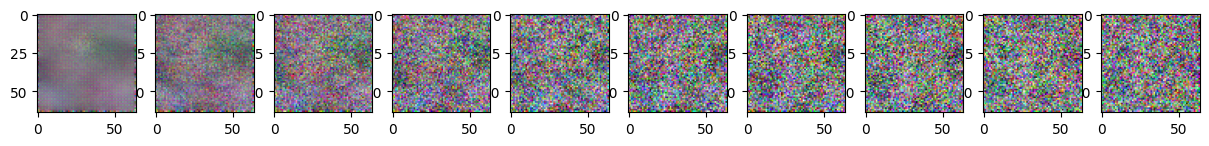

Epoch 10 | Loss: 0.13886600732803345 


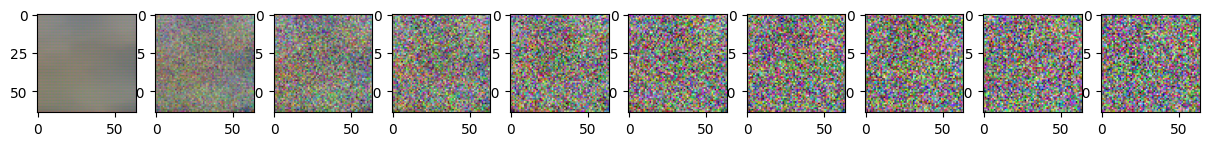

Epoch 20 | Loss: 0.10377733409404755 


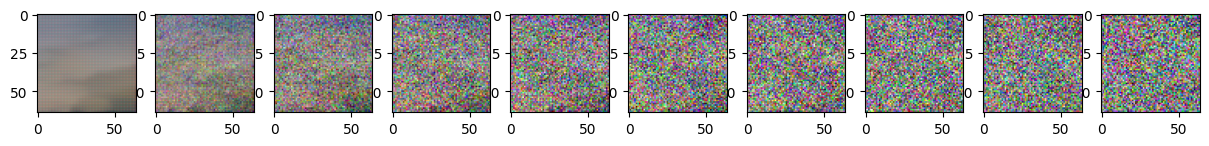

Epoch 30 | Loss: 0.13282448053359985 


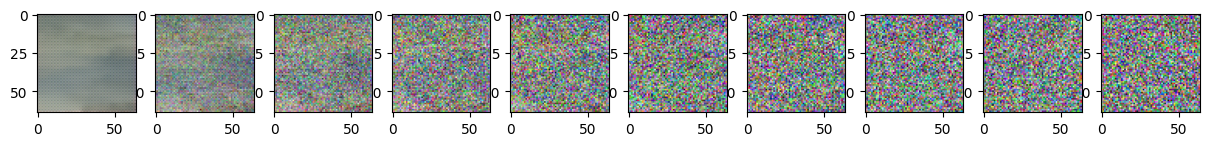

Epoch 40 | Loss: 0.11646518856287003 


Epoch 50 | Loss: 0.10598593205213547 


Epoch 60 | Loss: 0.10201232880353928 


Epoch 70 | Loss: 0.10103918612003326 


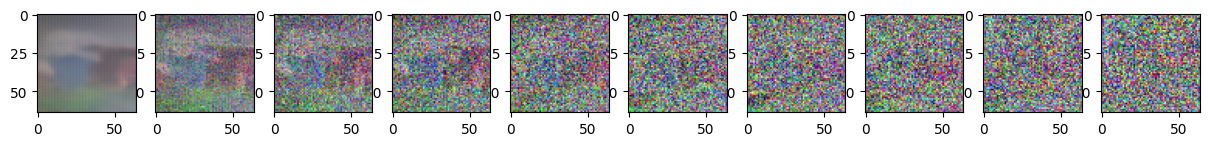

Epoch 80 | Loss: 0.13241133093833923 


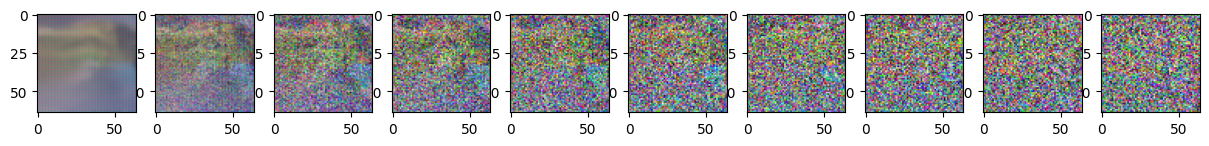

Epoch 90 | Loss: 0.11596687883138657 


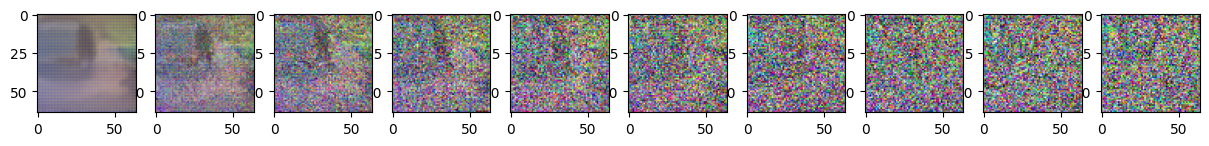

Epoch 100 | Loss: 0.11785892397165298 


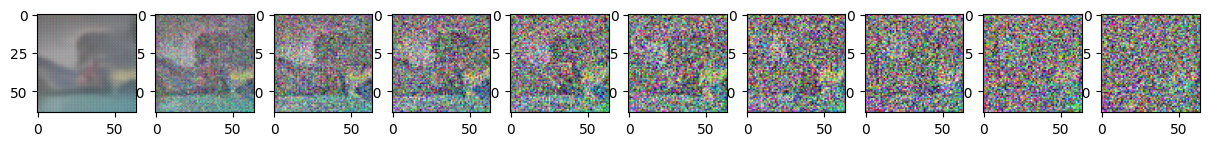

CPU times: user 1h 18min 19s, sys: 1min 42s, total: 1h 20min 2s
Wall time: 1h 27min 48s


In [ ]:
%%time
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (batch[0].shape[0],), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
    if (epoch == 0) or ((epoch+1)%10 == 0):
        print(f"Epoch {epoch+1} | Loss: {loss.item()} ")
        sample_and_plot_image()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/epoch100.pt')

In [ ]:
recreated_weights = torch.load('/content/drive/MyDrive/epoch100.pt')

In [ ]:
model = SimpleUnet()
model.load_state_dict(recreated_weights)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 100

Epoch 110 | Loss: 0.0909353718161583 


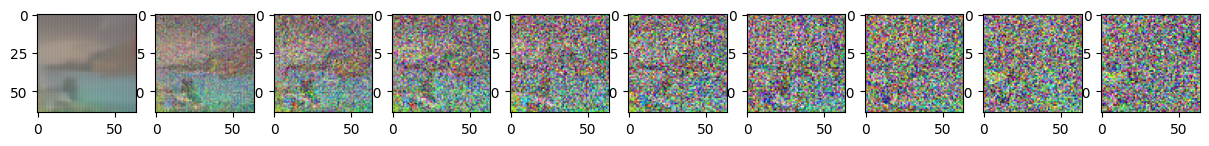

Epoch 120 | Loss: 0.11401203274726868 


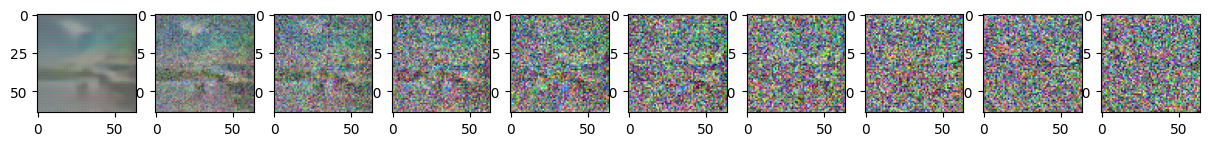

Epoch 130 | Loss: 0.09962354600429535 


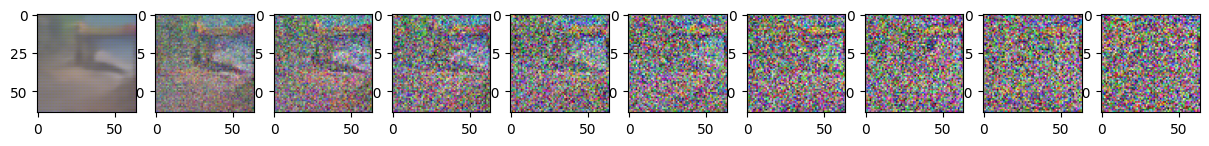

Epoch 140 | Loss: 0.11006864905357361 


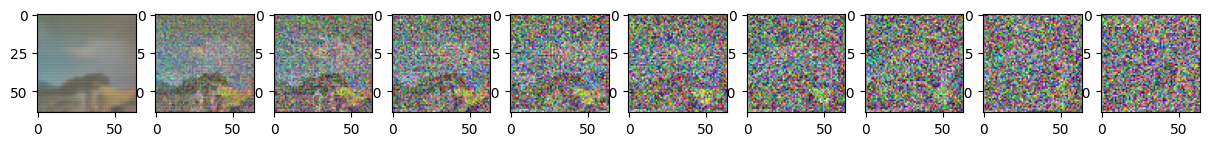

Epoch 150 | Loss: 0.10999132692813873 


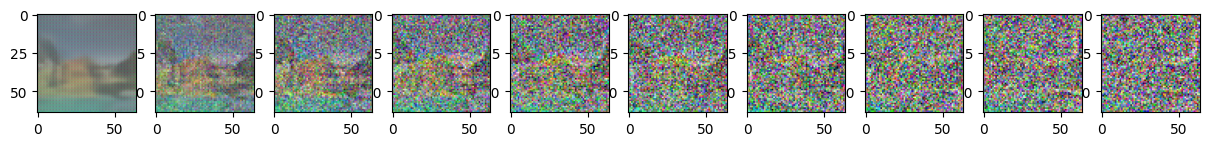

Epoch 160 | Loss: 0.10302085429430008 


Epoch 170 | Loss: 0.08709803223609924 


Epoch 180 | Loss: 0.10844366252422333 


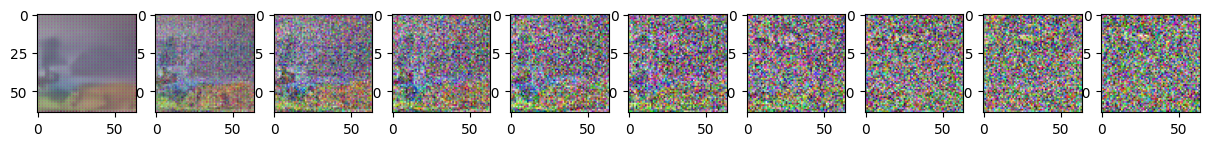

Epoch 190 | Loss: 0.11896125227212906 


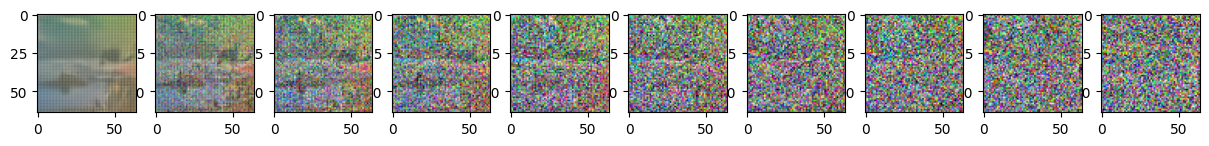

Epoch 200 | Loss: 0.09400315582752228 


CPU times: user 1h 20min 18s, sys: 1min 46s, total: 1h 22min 4s
Wall time: 1h 29min 48s


In [ ]:
# продолжение обучения
%%time
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (batch[0].shape[0],), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()
    if ((epoch+1)%10 == 0):
        print(f"Epoch {epoch+101} | Loss: {loss.item()} ")
        sample_and_plot_image()

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/epoch200.pt')

## Генерация и сохранение изображений

In [17]:
def get_ddpm_model(device = device):
  recreated_weights = torch.load('/content/drive/MyDrive/epoch200.pt')
  model = SimpleUnet()
  model.load_state_dict(recreated_weights)
  return model.to(device)

In [18]:
@torch.no_grad()
def generate_n_samples(n = 24):
  noise = torch.randn((n, 3, img_size, img_size), device=device)
  images = []
  for j in range (n):
    img = noise[j].reshape(1, 3, img_size, img_size)
    for i in range(0,T)[::-1]:
      t = torch.full((1,), i, device=device, dtype=torch.long)
      img = sample_timestep(img, t)
    images+=[img]
    images_generated = torch.cat(tuple(images),0)
  return images_generated

In [ ]:
test_generated = generate_n_samples(n = 24).data.cpu()
save_path = '/content/drive/MyDrive/ddpm_generated_images_epoch_200.png'
vutils.save_image(generate_n_samples(), save_path, normalize=True)

## FID

FID вычисляется для n = batch_size*3 = 192 реальных и сгенерированных изображений из-за ограниченной вычислительной мощности (генерация 4319 изображений займет более 4 часов)

In [19]:
def get_inception_v3(device = device):
  return inception_v3(pretrained=True, transform_input=False).eval().to(device)

In [20]:
@torch.no_grad()
def get_real_activations(dataloader = dataloader): #карта активации последнего слоя Inception для реальных изображений
  real_activations = []
  inception = get_inception_v3()
  upsample = nn.Upsample(scale_factor=2, mode='nearest') #апсемплинг инпутов для Inception (размер 64х64 ниже минимального)
  for (step,(images,_)) in enumerate(dataloader):
    images = upsample(images).to(device)
    activations = inception(images)
    real_activations.append(activations)
    if step == 2:
      break
  real_features = torch.cat(real_activations, 0)
  return real_features.cpu().numpy()

In [21]:
@torch.no_grad()
def get_fake_activations(fake_samples): #карта активации последнего слоя Inception для фэйковых изображений
  inception = get_inception_v3()
  upsample = nn.Upsample(scale_factor=2, mode='nearest')
  samples = upsample(fake_samples)
  activations = inception(samples)
  return activations.cpu().numpy()

In [22]:
# FID score
def calculate_fid(act1: np.array, act2: np.array):
  # среднее и матрица ковариации
  mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
  mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
  # сумма квадратов разности
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # корень произведения матриц
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  # проверка на комплексные значения
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # FID
  return ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

In [23]:
%%time
real_activations = get_real_activations()

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 103MB/s] 


CPU times: user 5.24 s, sys: 1.71 s, total: 6.95 s
Wall time: 1min 19s


In [24]:
real_activations.shape

(192, 1000)

In [25]:
%%time
model = get_ddpm_model()
samples = generate_n_samples(n = batch_size*3)

CPU times: user 15min 45s, sys: 1.67 s, total: 15min 47s
Wall time: 16min 5s


In [26]:
samples.shape

torch.Size([192, 3, 64, 64])

In [27]:
%%time
fake_activations = get_fake_activations(fake_samples = samples)

CPU times: user 567 ms, sys: 95.9 ms, total: 663 ms
Wall time: 680 ms


In [28]:
fake_activations.shape

(192, 1000)

In [29]:
fid_score = calculate_fid(real_activations, fake_activations)
fid_score

6857.204870856982